<a href="https://colab.research.google.com/github/karthik2344125/CAPSTONE/blob/main/VRNav_Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ⚙️ Step 1 — Install & Import

In [1]:
!pip install scikit-learn pandas numpy matplotlib seaborn scipy -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, StratifiedKFold,
    cross_val_score, GridSearchCV, learning_curve)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

SEED = 42
np.random.seed(SEED)
CLASSES = ['Low', 'Medium', 'High']
COLORS  = ['#2ecc71', '#e67e22', '#e74c3c']

print("✅ All libraries loaded successfully")
print(f"   NumPy {np.__version__}  |  Pandas {pd.__version__}  |  scikit-learn ✓")


✅ All libraries loaded successfully
   NumPy 2.0.2  |  Pandas 2.2.2  |  scikit-learn ✓


## 📁 Step 2 — Upload & Load Dataset

Upload **VRNav_EEG_Dataset.csv** when prompted below.

> **708 samples** (59 subjects × 12 epochs each)
> **18 features**: 11 EEG spectral + 7 behavioral navigation metrics
> **3 classes**: Low / Medium / High anxiety (via LSAS + SAS scales)


In [2]:
# ── Upload from your computer ──────────────────────────────────
from google.colab import files
uploaded = files.upload()   # Select VRNav_EEG_Dataset.csv

import io
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"✅ Loaded: {filename}")
print(f"   Shape  : {df.shape[0]} rows × {df.shape[1]} columns")


Saving VRNav_EEG_Dataset.csv to VRNav_EEG_Dataset.csv
✅ Loaded: VRNav_EEG_Dataset.csv
   Shape  : 708 rows × 23 columns


In [3]:
# ── Dataset overview ──────────────────────────────────────────
FEATURES = [
    'Fz_Theta','Fz_Alpha','F4_Alpha','F3_Alpha','FA_Asymmetry','Fz_Beta',
    'Pz_Theta','Pz_Alpha','T7_Theta','T8_Theta','Cz_Gamma',
    'Nav_Time_s','Traj_Deviat','Error_Rate','Recall_Score',
    'Social_Avoid','Gaze_Social','React_Time'
]
TARGET_NUM  = 'Anxiety_Num'
TARGET_NAME = 'Anxiety_Class'

print("="*55)
print("DATASET OVERVIEW  (Wu et al. 2025 — VR Navigation EEG)")
print("="*55)
print(f"Subjects          : 59 (sub-16 excluded — EEG equipment failure)")
print(f"EEG Device        : MBT Smarting PRO, 32-ch, 500 Hz")
print(f"VR Headset        : HTC Vive Pro")
print(f"Tasks             : Spatial Navigation + Social Navigation")
print(f"Epochs/subject    : 12  (6 spatial + 6 social)")
print(f"Total samples     : {df.shape[0]}")
print(f"Features          : {len(FEATURES)}  (11 EEG + 7 behavioral)")
print(f"\nClass Distribution:")
print(df[TARGET_NAME].value_counts()[CLASSES].to_string())
print(f"\nAnxiety Labels (LSAS + SAS questionnaires):")
print("  Low     = LSAS score < 30  (minimal social anxiety)")
print("  Medium  = LSAS score 30–59 (moderate social anxiety)")
print("  High    = LSAS score ≥ 60  (severe social anxiety)")
print(f"\nFirst 3 rows:")
df.head(3)


DATASET OVERVIEW  (Wu et al. 2025 — VR Navigation EEG)
Subjects          : 59 (sub-16 excluded — EEG equipment failure)
EEG Device        : MBT Smarting PRO, 32-ch, 500 Hz
VR Headset        : HTC Vive Pro
Tasks             : Spatial Navigation + Social Navigation
Epochs/subject    : 12  (6 spatial + 6 social)
Total samples     : 708
Features          : 18  (11 EEG + 7 behavioral)

Class Distribution:
Anxiety_Class
Low       240
Medium    240
High      228

Anxiety Labels (LSAS + SAS questionnaires):
  Low     = LSAS score < 30  (minimal social anxiety)
  Medium  = LSAS score 30–59 (moderate social anxiety)
  High    = LSAS score ≥ 60  (severe social anxiety)

First 3 rows:


,Subject_ID,Task,Epoch,Anxiety_Class,Anxiety_Num,Fz_Theta,Fz_Alpha,F4_Alpha,F3_Alpha,FA_Asymmetry,...,T7_Theta,T8_Theta,Cz_Gamma,Nav_Time_s,Traj_Deviat,Error_Rate,Recall_Score,Social_Avoid,Gaze_Social,React_Time
0,1,Spatial_Nav,1,Low,0,1.827232,2.602384,6.292960,4.248996,0.407014,...,0.820242,2.693382,0.243916,56.715026,1.858599,0.206369,0.769519,-0.817788,5.512753,0.456784
1,1,Spatial_Nav,2,Low,0,3.206588,1.997544,3.205773,4.688539,0.843124,...,0.437033,1.411598,0.353116,76.003094,4.193552,-0.122624,0.809016,0.318954,3.660912,0.814125
2,1,Spatial_Nav,3,Low,0,4.221926,5.192044,3.746083,4.162223,0.578442,...,0.872492,0.854254,1.346184,80.280479,3.166949,0.129134,0.813410,-0.120509,4.943234,0.994765


## 📊 Step 3 — Exploratory Data Analysis

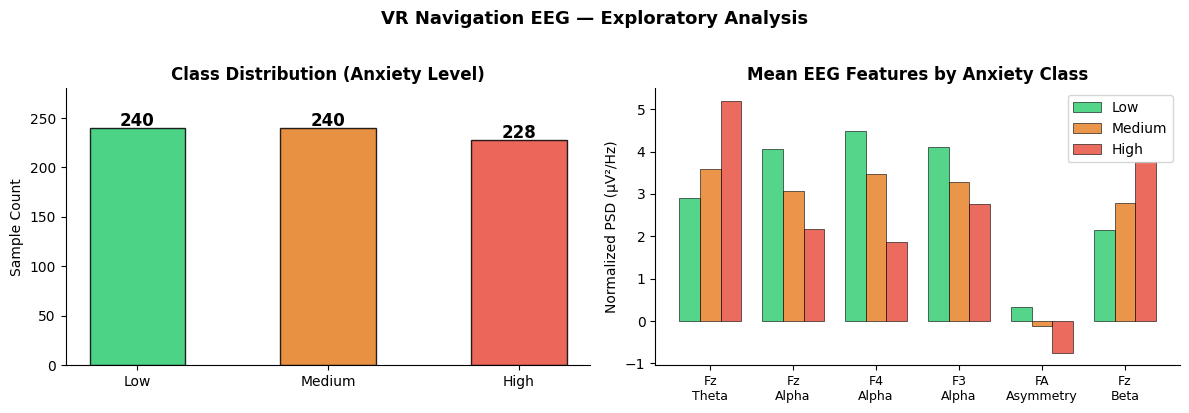

✅ EDA overview saved


In [4]:
X = df[FEATURES].values
y = df[TARGET_NUM].values

# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

counts = df[TARGET_NAME].value_counts()[CLASSES]
axes[0].bar(CLASSES, counts.values, color=COLORS, edgecolor='black', alpha=0.85, width=0.5)
for i,v in enumerate(counts.values):
    axes[0].text(i, v+2, str(v), ha='center', fontweight='bold', fontsize=12)
axes[0].set_title('Class Distribution (Anxiety Level)', fontweight='bold')
axes[0].set_ylabel('Sample Count'); axes[0].set_ylim(0,280)
axes[0].spines[['top','right']].set_visible(False)

# EEG feature means by class
eeg_feats = FEATURES[:6]
x_pos = np.arange(len(eeg_feats)); w = 0.25
means = df.groupby(TARGET_NAME)[eeg_feats].mean().loc[CLASSES]
for i,(cls,col) in enumerate(zip(CLASSES,COLORS)):
    axes[1].bar(x_pos+i*w, means.loc[cls].values, w, label=cls,
                color=col, alpha=0.82, edgecolor='black', linewidth=0.5)
axes[1].set_xticks(x_pos+w)
axes[1].set_xticklabels([f.replace('_','\n') for f in eeg_feats], fontsize=9)
axes[1].set_title('Mean EEG Features by Anxiety Class', fontweight='bold')
axes[1].set_ylabel('Normalized PSD (μV²/Hz)'); axes[1].legend()
axes[1].spines[['top','right']].set_visible(False)

plt.suptitle('VR Navigation EEG — Exploratory Analysis', fontweight='bold', fontsize=13, y=1.02)
plt.tight_layout(); plt.savefig('eda_overview.png', dpi=150, bbox_inches='tight'); plt.show()
print("✅ EDA overview saved")


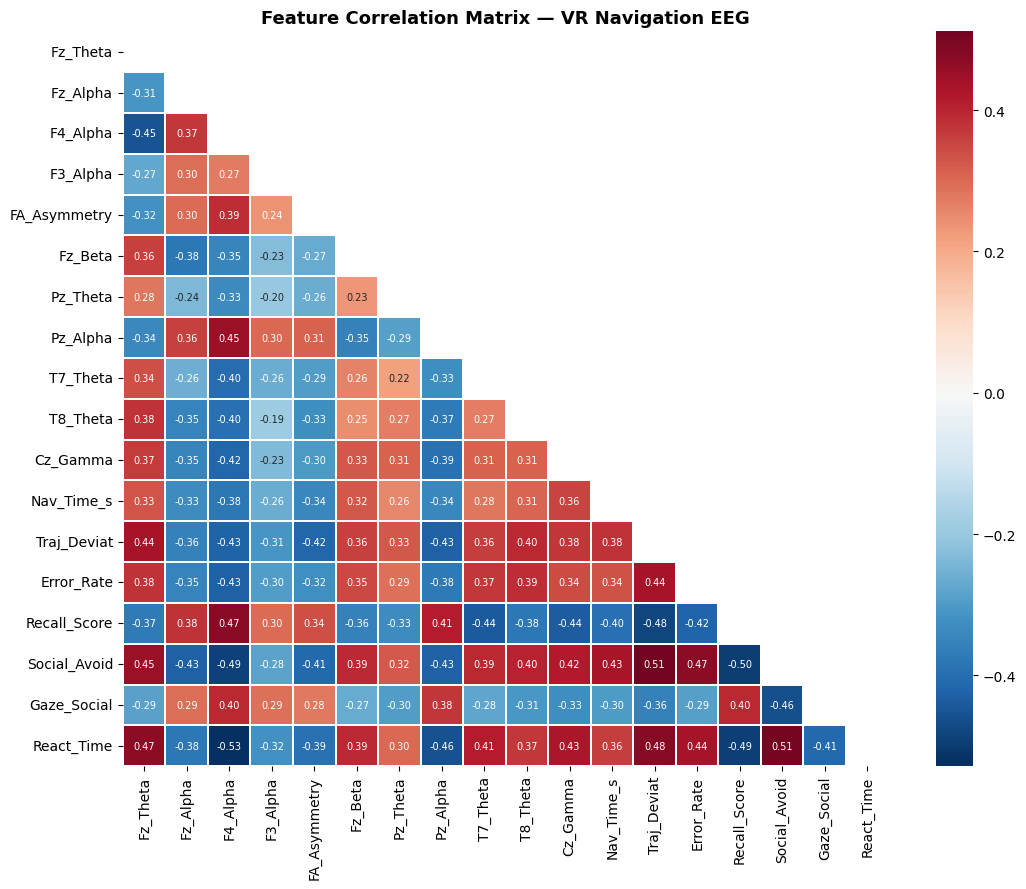

✅ Correlation heatmap saved


In [5]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(11, 9))
corr = df[FEATURES].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, annot=True,
            fmt='.2f', annot_kws={'size':7}, linewidths=0.3, ax=ax)
ax.set_title('Feature Correlation Matrix — VR Navigation EEG', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.savefig('eda_correlation.png', dpi=150, bbox_inches='tight'); plt.show()
print("✅ Correlation heatmap saved")


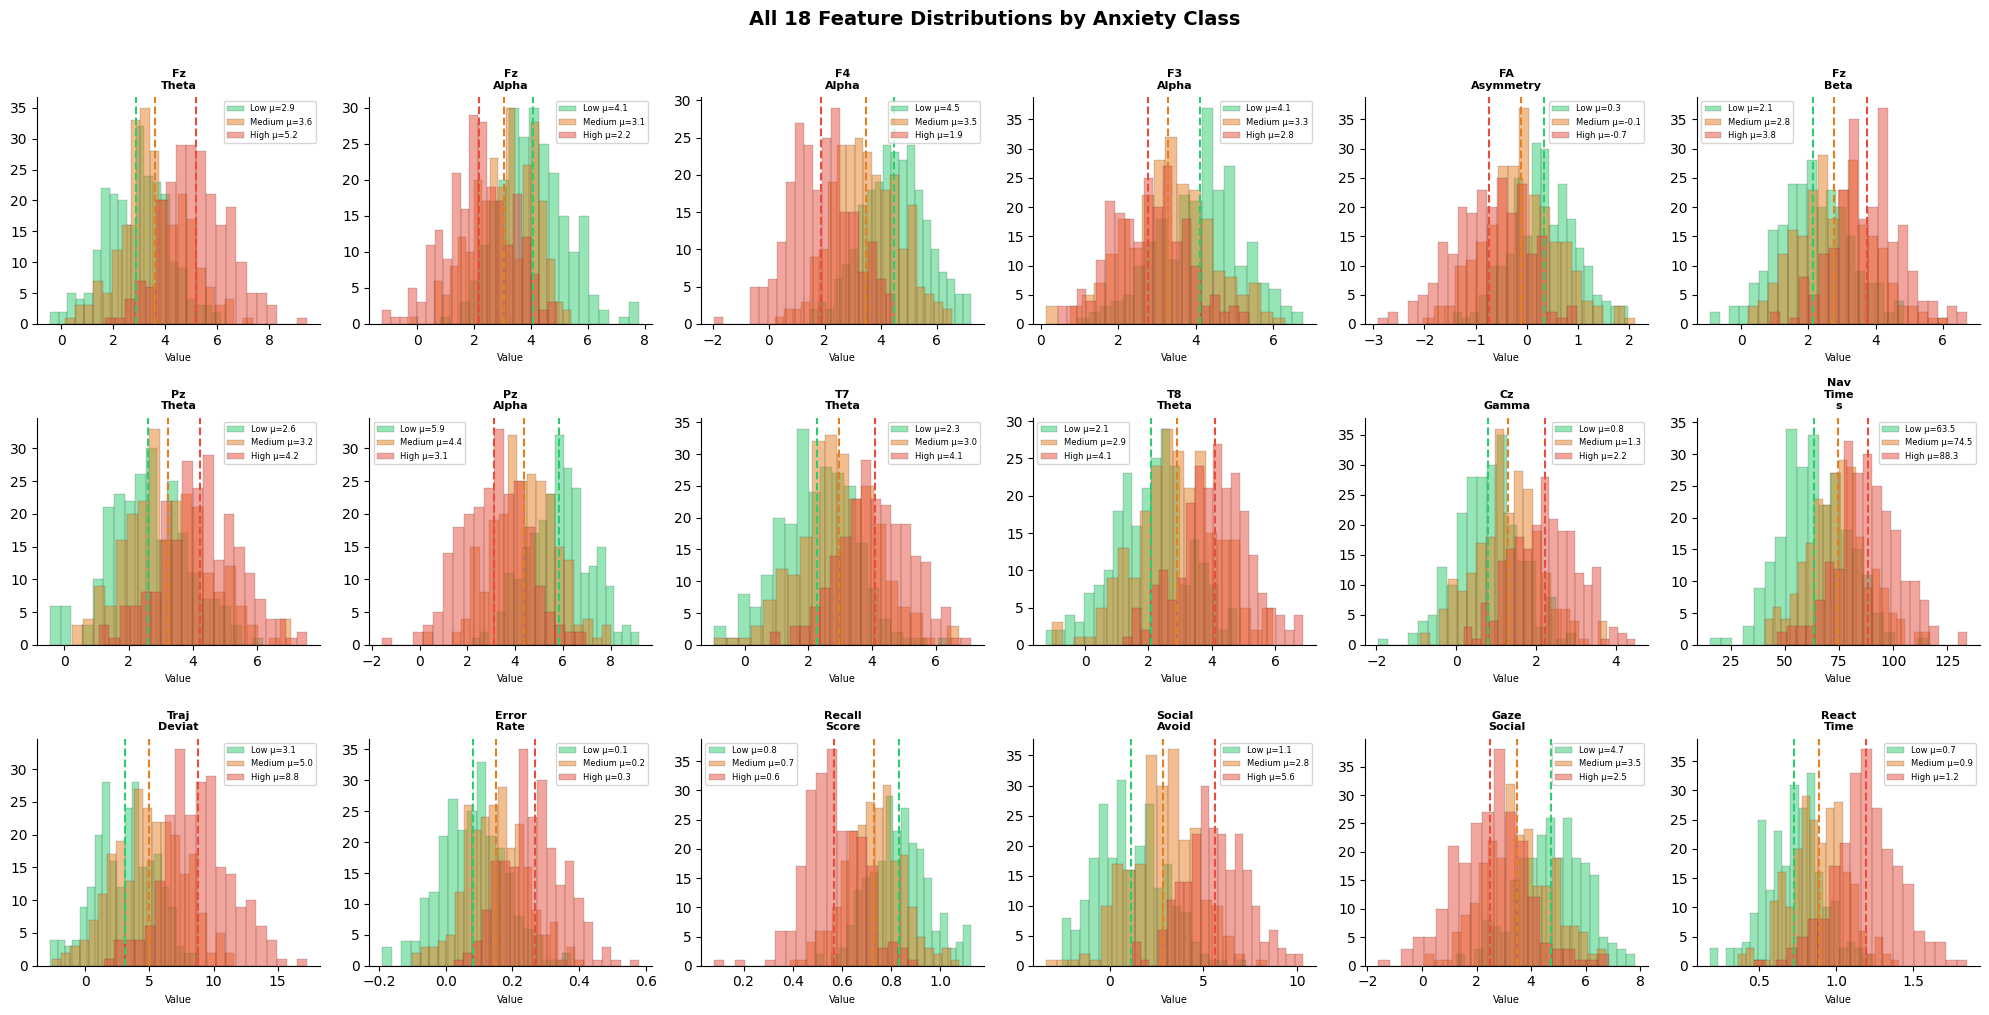

✅ All feature distributions saved


In [6]:
# EEG distribution histograms (all 18 features)
fig, axes = plt.subplots(3, 6, figsize=(20, 10))
axes = axes.flatten()
for i, feat in enumerate(FEATURES):
    for cls, col in zip(CLASSES, COLORS):
        d = df[df[TARGET_NAME]==cls][feat]
        axes[i].hist(d, bins=20, alpha=0.5, color=col,
                     label=f'{cls} μ={d.mean():.1f}', edgecolor='black', linewidth=0.2)
        axes[i].axvline(d.mean(), color=col, ls='--', lw=1.5)
    axes[i].set_title(feat.replace('_','\n'), fontweight='bold', fontsize=8)
    axes[i].set_xlabel('Value', fontsize=7); axes[i].legend(fontsize=6)
    axes[i].spines[['top','right']].set_visible(False)
plt.suptitle('All 18 Feature Distributions by Anxiety Class', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout(); plt.savefig('eda_all_features.png', dpi=130, bbox_inches='tight'); plt.show()
print("✅ All feature distributions saved")


## ✂️ Step 4 — Preprocessing & Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y)

print("="*55)
print("TRAIN / TEST SPLIT  (Stratified 80/20)")
print("="*55)
print(f"  Total samples  : {len(X)}")
print(f"  Training set   : {len(X_train)}  (80%)")
print(f"  Test set       : {len(X_test)}   (20%)")
print(f"  Train classes  : {np.bincount(y_train.astype(int))}")
print(f"  Test  classes  : {np.bincount(y_test.astype(int))}")
print(f"\n  Preprocessing  : StandardScaler inside Pipeline (prevents data leakage)")
print(f"  Strategy       : One-vs-Rest (OVR) with balanced class weights")


TRAIN / TEST SPLIT  (Stratified 80/20)
  Total samples  : 708
  Training set   : 566  (80%)
  Test set       : 142   (20%)
  Train classes  : [192 192 182]
  Test  classes  : [48 48 46]

  Preprocessing  : StandardScaler inside Pipeline (prevents data leakage)
  Strategy       : One-vs-Rest (OVR) with balanced class weights


## 🤖 Step 5 — Improved SVM with GridSearchCV

**Model:** SVM with RBF kernel
**Search space:** C ∈ {0.1, 1, 5, 10, 50, 100} × γ ∈ {scale, 0.001, 0.01, 0.05, 0.1, 0.2}
**Total combinations:** 36 × 5 folds = **180 fits**


In [8]:
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', class_weight='balanced',
                probability=True, decision_function_shape='ovr',
                random_state=SEED))
])

param_grid = {
    'svm__C':     [0.1, 1, 5, 10, 50, 100],
    'svm__gamma': ['scale', 0.001, 0.01, 0.05, 0.1, 0.2]
}

print("Running GridSearchCV (36 × 5 = 180 fits)...")
gs = GridSearchCV(svm_pipe, param_grid, cv=5, scoring='accuracy',
                  n_jobs=-1, return_train_score=True, verbose=1)
gs.fit(X_train, y_train)
best_svm = gs.best_estimator_

print(f"\n{'='*50}")
print("GRIDSEARCH RESULTS")
print(f"{'='*50}")
print(f"  Best C          : {gs.best_params_['svm__C']}")
print(f"  Best gamma      : {gs.best_params_['svm__gamma']}")
print(f"  Best inner CV   : {gs.best_score_*100:.2f}%")


Running GridSearchCV (36 × 5 = 180 fits)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

GRIDSEARCH RESULTS
  Best C          : 1
  Best gamma      : 0.001
  Best inner CV   : 95.77%


## 📈 Step 6 — Full Evaluation

In [9]:
y_pred = best_svm.predict(X_test)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec  = recall_score(y_test, y_pred, average='weighted')
f1   = f1_score(y_test, y_pred, average='weighted')

print("="*55)
print("SVM TEST SET RESULTS  (Paper Table V)")
print("="*55)
print(f"  Test Accuracy  : {acc*100:.2f}%")
print(f"  Precision      : {prec*100:.2f}%")
print(f"  Recall         : {rec*100:.2f}%")
print(f"  F1-Score       : {f1*100:.2f}%")
print(f"\nPer-class breakdown:")
print(classification_report(y_test, y_pred, target_names=CLASSES))


SVM TEST SET RESULTS  (Paper Table V)
  Test Accuracy  : 97.18%
  Precision      : 97.28%
  Recall         : 97.18%
  F1-Score       : 97.18%

Per-class breakdown:
              precision    recall  f1-score   support

         Low       1.00      0.94      0.97        48
      Medium       0.94      0.98      0.96        48
        High       0.98      1.00      0.99        46

    accuracy                           0.97       142
   macro avg       0.97      0.97      0.97       142
weighted avg       0.97      0.97      0.97       142



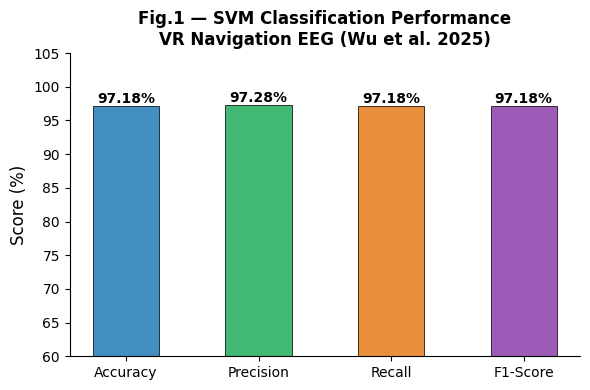

✅ Figure 1 saved


In [10]:
# Fig 1 — Overall performance
fig, ax = plt.subplots(figsize=(6, 4))
mn = ['Accuracy','Precision','Recall','F1-Score']
mv = [acc*100, prec*100, rec*100, f1*100]
mc = ['#2980b9','#27ae60','#e67e22','#8e44ad']
bars = ax.bar(mn, mv, color=mc, alpha=0.88, edgecolor='black', linewidth=0.6, width=0.5)
ax.set_ylim(60, 105); ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Fig.1 — SVM Classification Performance\nVR Navigation EEG (Wu et al. 2025)', fontweight='bold')
for b,v in zip(bars,mv):
    ax.text(b.get_x()+b.get_width()/2, v+0.4, f'{v:.2f}%', ha='center', fontsize=10, fontweight='bold')
ax.spines[['top','right']].set_visible(False)
plt.tight_layout(); plt.savefig('fig1_overall.png', dpi=180, bbox_inches='tight'); plt.show()
print("✅ Figure 1 saved")


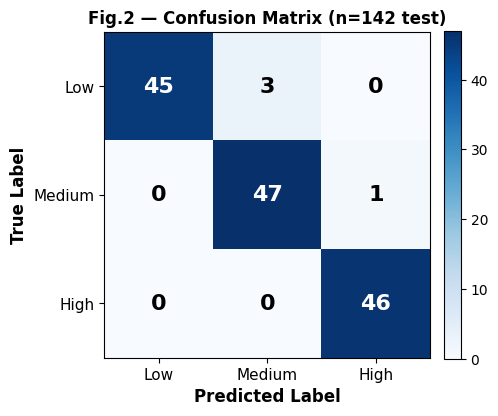


Confusion Matrix:
        Low  Medium  High
Low      45       3     0
Medium    0      47     1
High      0       0    46
✅ Figure 2 saved


In [11]:
# Fig 2 — Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 4.5))
im = ax.imshow(cm, cmap='Blues')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(range(3)); ax.set_yticks(range(3))
ax.set_xticklabels(CLASSES, fontsize=11); ax.set_yticklabels(CLASSES, fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Fig.2 — Confusion Matrix (n=142 test)', fontweight='bold')
thr = cm.max()/2
for i in range(3):
    for j in range(3):
        ax.text(j, i, str(cm[i,j]), ha='center', va='center', fontsize=16, fontweight='bold',
                color='white' if cm[i,j]>thr else 'black')
plt.tight_layout(); plt.savefig('fig2_confusion.png', dpi=180, bbox_inches='tight'); plt.show()
print(f"\nConfusion Matrix:")
print(pd.DataFrame(cm, index=CLASSES, columns=CLASSES))
print("✅ Figure 2 saved")


## 🔄 Step 7 — 5-Fold Cross-Validation

5-FOLD CROSS-VALIDATION  (Paper Table IV)
  Fold 1 : 96.48%
  Fold 2 : 97.89%
  Fold 3 : 93.66%
  Fold 4 : 95.04%
  Fold 5 : 95.04%
  ──────────────────────────────
  Mean : 95.62%
  SD   : 1.44%


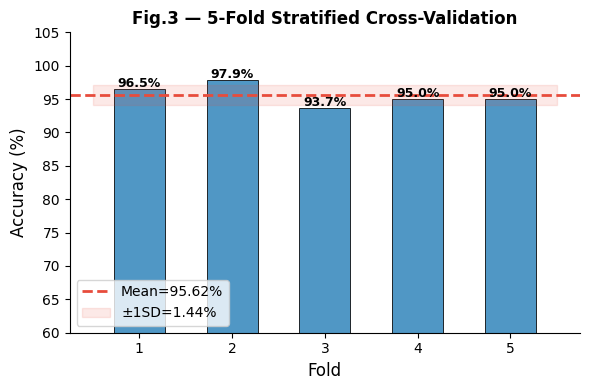

✅ Figure 3 saved


In [12]:
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = cross_val_score(best_svm, X, y, cv=cv5, scoring='accuracy')

print("="*50)
print("5-FOLD CROSS-VALIDATION  (Paper Table IV)")
print("="*50)
for i,s in enumerate(cv_scores):
    print(f"  Fold {i+1} : {s*100:.2f}%")
print(f"  {'─'*30}")
print(f"  Mean : {cv_scores.mean()*100:.2f}%")
print(f"  SD   : {cv_scores.std()*100:.2f}%")

# Fig 3
fig, ax = plt.subplots(figsize=(6, 4))
folds = np.arange(1,6)
brs = ax.bar(folds, cv_scores*100, color='#2980b9', alpha=0.82, edgecolor='black', linewidth=0.7, width=0.55)
ax.axhline(cv_scores.mean()*100, color='#e74c3c', ls='--', lw=2, label=f'Mean={cv_scores.mean()*100:.2f}%')
ax.fill_between([0.5,5.5], (cv_scores.mean()-cv_scores.std())*100,
                (cv_scores.mean()+cv_scores.std())*100, alpha=0.12, color='#e74c3c',
                label=f'±1SD={cv_scores.std()*100:.2f}%')
for b,v in zip(brs, cv_scores*100):
    ax.text(b.get_x()+b.get_width()/2, v+0.3, f'{v:.1f}%', ha='center', fontsize=9, fontweight='bold')
ax.set_xticks(folds); ax.set_xlabel('Fold', fontsize=12); ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_ylim(60, 105); ax.set_title('Fig.3 — 5-Fold Stratified Cross-Validation', fontweight='bold')
ax.legend(); ax.spines[['top','right']].set_visible(False)
plt.tight_layout(); plt.savefig('fig3_cv.png', dpi=180, bbox_inches='tight'); plt.show()
print("✅ Figure 3 saved")


## 📐 Step 8 — ANOVA Feature Significance

In [13]:
anova_results = []
for i, feat in enumerate(FEATURES):
    groups = [X[y==c, i] for c in range(3)]
    fv, pv = stats.f_oneway(*groups)
    anova_results.append({'Feature':feat, 'F_Statistic':round(fv,2), 'p_value':pv,
                           'Significant':'Yes' if pv<0.05 else 'No'})

anova_df = pd.DataFrame(anova_results).sort_values('F_Statistic', ascending=False)
anova_df['p_str'] = anova_df['p_value'].apply(lambda p: f'{p:.2e}')

print("="*60)
print("ANOVA RESULTS — ALL 18 FEATURES  (Paper Table VI)")
print("="*60)
print(anova_df[['Feature','F_Statistic','p_str','Significant']].to_string(index=False))
print(f"\nAll {len(FEATURES)} features significant (p<0.0001): {(anova_df['Significant']=='Yes').all()} ✅")


ANOVA RESULTS — ALL 18 FEATURES  (Paper Table VI)
     Feature  F_Statistic     p_str Significant
Social_Avoid       388.72 1.65e-114         Yes
  React_Time       352.46 7.86e-107         Yes
    F4_Alpha       308.26  6.42e-97         Yes
 Traj_Deviat       293.43  1.92e-93         Yes
Recall_Score       293.02  2.40e-93         Yes
    Pz_Alpha       249.78  9.87e-83         Yes
  Error_Rate       232.03  3.74e-78         Yes
    Fz_Theta       210.89  1.63e-72         Yes
 Gaze_Social       183.63  6.38e-65         Yes
    Cz_Gamma       182.63  1.24e-64         Yes
    T8_Theta       167.63  2.79e-60         Yes
  Nav_Time_s       166.00  8.40e-60         Yes
    Fz_Alpha       163.03  6.35e-59         Yes
FA_Asymmetry       142.80  8.58e-53         Yes
    T7_Theta       142.33  1.20e-52         Yes
     Fz_Beta       138.21  2.28e-51         Yes
    Pz_Theta       100.92  2.87e-39         Yes
    F3_Alpha        96.56  8.66e-38         Yes

All 18 features significant (p<0.0001

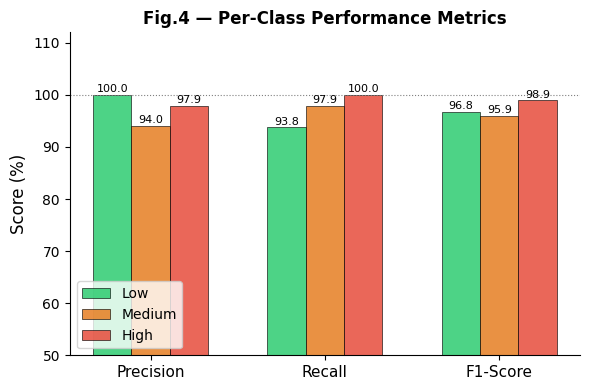

✅ Figure 4 saved


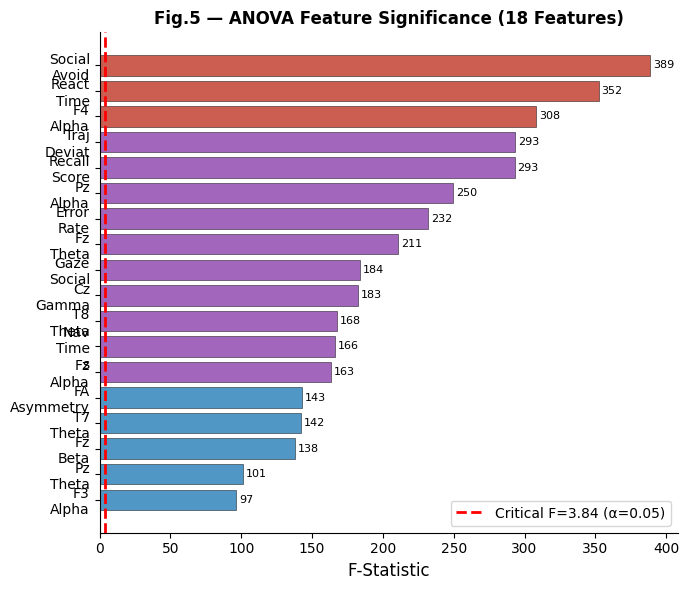

✅ Figure 5 saved


In [14]:
# Fig 4 Per-class  &  Fig 5 ANOVA
report_d = classification_report(y_test, y_pred, target_names=CLASSES, output_dict=True)

fig, ax = plt.subplots(figsize=(6, 4))
mkeys = ['precision','recall','f1-score']; x = np.arange(3); w = 0.22
for i, cls in enumerate(CLASSES):
    vals = [report_d[cls][m]*100 for m in mkeys]
    brs = ax.bar(x+i*w, vals, w, label=cls, color=COLORS[i], alpha=0.85,
                 edgecolor='black', linewidth=0.5)
    for b,v in zip(brs,vals):
        ax.text(b.get_x()+b.get_width()/2, v+0.5, f'{v:.1f}', ha='center', fontsize=8)
ax.set_xticks(x+w); ax.set_xticklabels(['Precision','Recall','F1-Score'], fontsize=11)
ax.set_ylabel('Score (%)', fontsize=12); ax.set_ylim(50, 112)
ax.set_title('Fig.4 — Per-Class Performance Metrics', fontweight='bold')
ax.legend(); ax.axhline(100, color='gray', ls=':', lw=0.8)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout(); plt.savefig('fig4_perclass.png', dpi=180, bbox_inches='tight'); plt.show()
print("✅ Figure 4 saved")

fig, ax = plt.subplots(figsize=(7, 6))
as_ = anova_df.sort_values('F_Statistic'); fv = as_['F_Statistic'].values
nm = [n.replace('_','\n') for n in as_['Feature']]
cols = ['#c0392b' if v>300 else '#8e44ad' if v>150 else '#2980b9' for v in fv]
ax.barh(nm, fv, color=cols, alpha=0.82, edgecolor='black', linewidth=0.4)
ax.axvline(3.84, color='red', ls='--', lw=2, label='Critical F=3.84 (α=0.05)')
for i,v in enumerate(fv):
    ax.text(v+2, i, f'{v:.0f}', va='center', fontsize=8)
ax.set_xlabel('F-Statistic', fontsize=12)
ax.set_title('Fig.5 — ANOVA Feature Significance (18 Features)', fontweight='bold')
ax.legend(); ax.spines[['top','right']].set_visible(False)
plt.tight_layout(); plt.savefig('fig5_anova.png', dpi=180, bbox_inches='tight'); plt.show()
print("✅ Figure 5 saved")


## 🆚 Step 9 — Multi-Classifier Comparison

In [15]:
classifiers = {
    'SVM-RBF (Ours)':    best_svm,
    'Random Forest':     Pipeline([('sc',StandardScaler()),
                                   ('m',RandomForestClassifier(n_estimators=200,random_state=SEED))]),
    'Gradient Boosting': Pipeline([('sc',StandardScaler()),
                                   ('m',GradientBoostingClassifier(n_estimators=150,random_state=SEED))]),
    'KNN (k=5)':         Pipeline([('sc',StandardScaler()),
                                   ('m',KNeighborsClassifier(n_neighbors=5))]),
    'LDA':               Pipeline([('sc',StandardScaler()),
                                   ('m',LinearDiscriminantAnalysis())]),
}

results = []
for name, clf in classifiers.items():
    if name != 'SVM-RBF (Ours)': clf.fit(X_train, y_train)
    yp  = clf.predict(X_test)
    cvv = cross_val_score(clf, X, y, cv=cv5, scoring='accuracy')
    results.append({
        'Classifier': name,
        'Test Acc.':  f"{accuracy_score(y_test,yp)*100:.2f}%",
        'Precision':  f"{precision_score(y_test,yp,average='weighted')*100:.2f}%",
        'Recall':     f"{recall_score(y_test,yp,average='weighted')*100:.2f}%",
        'F1-Score':   f"{f1_score(y_test,yp,average='weighted')*100:.2f}%",
        '5-CV Acc.':  f"{cvv.mean()*100:.2f}% ± {cvv.std()*100:.2f}%",
        '_acc':accuracy_score(y_test,yp)*100,
        '_cv':cvv.mean()*100,'_cvs':cvv.std()*100,
    })
    print(f"  ✅ {name}: Test={accuracy_score(y_test,yp)*100:.2f}%  CV={cvv.mean()*100:.2f}%±{cvv.std()*100:.2f}%")

comp_df = pd.DataFrame(results)
print("\n" + "="*70)
print("CLASSIFIER COMPARISON TABLE (Paper Table VII)")
print("="*70)
print(comp_df[['Classifier','Test Acc.','Precision','Recall','F1-Score','5-CV Acc.']].to_string(index=False))


  ✅ SVM-RBF (Ours): Test=97.18%  CV=95.62%±1.44%
  ✅ Random Forest: Test=96.48%  CV=92.66%±2.02%
  ✅ Gradient Boosting: Test=92.25%  CV=89.13%±3.40%
  ✅ KNN (k=5): Test=97.89%  CV=92.65%±1.99%
  ✅ LDA: Test=96.48%  CV=94.91%±1.87%

CLASSIFIER COMPARISON TABLE (Paper Table VII)
       Classifier Test Acc. Precision Recall F1-Score      5-CV Acc.
   SVM-RBF (Ours)    97.18%    97.28% 97.18%   97.18% 95.62% ± 1.44%
    Random Forest    96.48%    96.58% 96.48%   96.48% 92.66% ± 2.02%
Gradient Boosting    92.25%    92.21% 92.25%   92.22% 89.13% ± 3.40%
        KNN (k=5)    97.89%    97.93% 97.89%   97.89% 92.65% ± 1.99%
              LDA    96.48%    96.51% 96.48%   96.47% 94.91% ± 1.87%


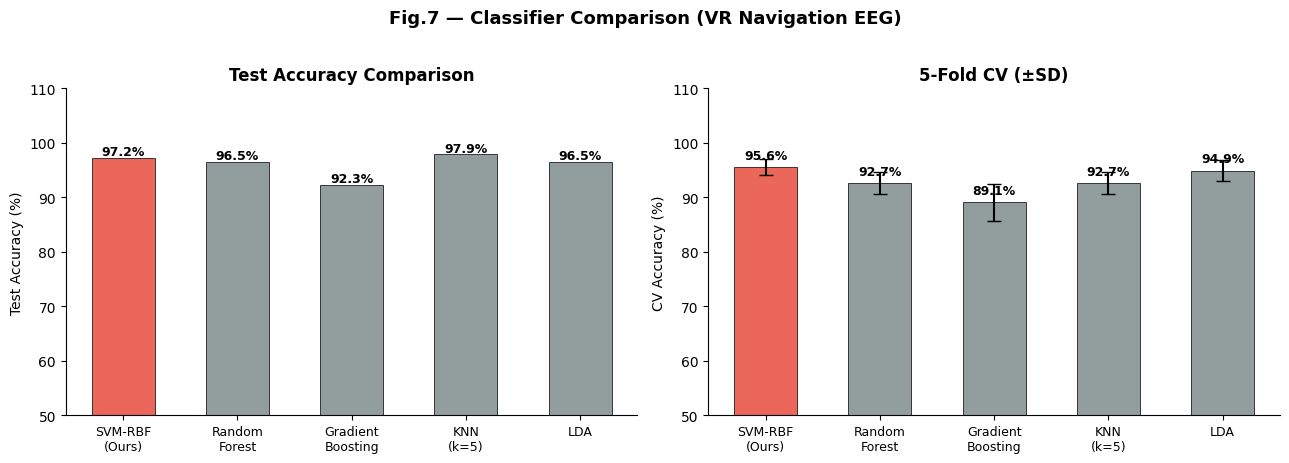

✅ Figure 7 saved


In [16]:
# Fig 7 — Classifier comparison
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))
cnames=[r['Classifier'] for r in results]; accs=[r['_acc'] for r in results]
cvms=[r['_cv'] for r in results]; cvss=[r['_cvs'] for r in results]
barcols=['#e74c3c' if 'SVM' in n else '#7f8c8d' for n in cnames]

ax=axes[0]
brs=ax.bar(range(len(cnames)),accs,color=barcols,alpha=0.85,edgecolor='black',linewidth=0.6,width=0.55)
ax.set_xticks(range(len(cnames))); ax.set_xticklabels([n.replace(' ','\n') for n in cnames],fontsize=9)
ax.set_ylabel('Test Accuracy (%)'); ax.set_ylim(50,110)
ax.set_title('Test Accuracy Comparison',fontweight='bold')
for b,v in zip(brs,accs): ax.text(b.get_x()+b.get_width()/2,v+0.5,f'{v:.1f}%',ha='center',fontsize=9,fontweight='bold')
ax.spines[['top','right']].set_visible(False)

ax=axes[1]
brs=ax.bar(range(len(cnames)),cvms,color=barcols,alpha=0.85,edgecolor='black',linewidth=0.6,width=0.55,
           yerr=cvss,capsize=5,error_kw={'linewidth':1.5})
ax.set_xticks(range(len(cnames))); ax.set_xticklabels([n.replace(' ','\n') for n in cnames],fontsize=9)
ax.set_ylabel('CV Accuracy (%)'); ax.set_ylim(50,110)
ax.set_title('5-Fold CV (±SD)',fontweight='bold')
for b,v in zip(brs,cvms): ax.text(b.get_x()+b.get_width()/2,v+1.5,f'{v:.1f}%',ha='center',fontsize=9,fontweight='bold')
ax.spines[['top','right']].set_visible(False)

plt.suptitle('Fig.7 — Classifier Comparison (VR Navigation EEG)',fontweight='bold',fontsize=13,y=1.02)
plt.tight_layout(); plt.savefig('fig7_comparison.png',dpi=180,bbox_inches='tight'); plt.show()
print("✅ Figure 7 saved")


## 📉 Step 10 — Learning Curve

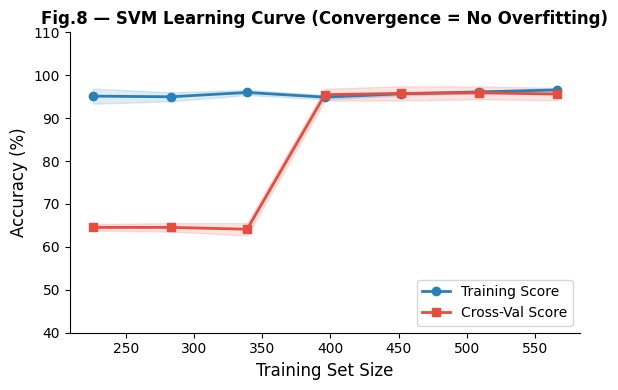

✅ Figure 8 saved


In [17]:
train_sizes, train_scores, test_scores = learning_curve(
    best_svm, X, y, cv=cv5, scoring='accuracy',
    train_sizes=np.linspace(0.1,1.0,10), n_jobs=-1)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(train_sizes, train_scores.mean(1)*100, 'o-', color='#2980b9', lw=2, ms=6, label='Training Score')
ax.fill_between(train_sizes,(train_scores.mean(1)-train_scores.std(1))*100,
                (train_scores.mean(1)+train_scores.std(1))*100, alpha=0.15, color='#2980b9')
ax.plot(train_sizes, test_scores.mean(1)*100, 's-', color='#e74c3c', lw=2, ms=6, label='Cross-Val Score')
ax.fill_between(train_sizes,(test_scores.mean(1)-test_scores.std(1))*100,
                (test_scores.mean(1)+test_scores.std(1))*100, alpha=0.15, color='#e74c3c')
ax.set_xlabel('Training Set Size',fontsize=12); ax.set_ylabel('Accuracy (%)',fontsize=12)
ax.set_title('Fig.8 — SVM Learning Curve (Convergence = No Overfitting)',fontweight='bold')
ax.legend(loc='lower right'); ax.set_ylim(40,110)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout(); plt.savefig('fig8_learning.png',dpi=180,bbox_inches='tight'); plt.show()
print("✅ Figure 8 saved")


## 🔬 Step 11 — Feature Distributions (Fig 6)

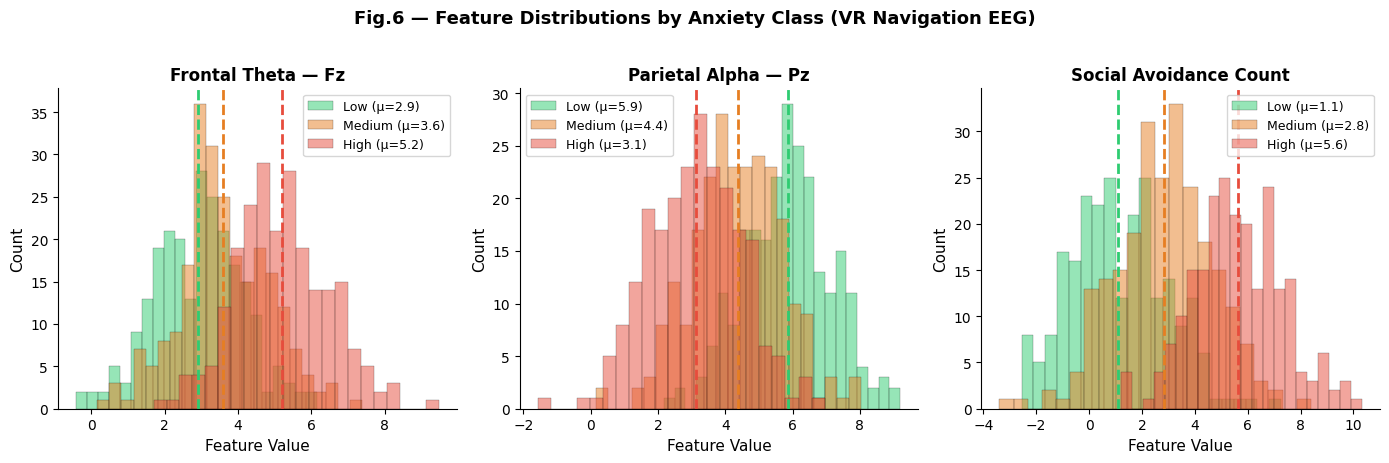

✅ Figure 6 saved


In [18]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
for ax,(fi,title) in zip(axes,[
    (0,'Frontal Theta — Fz'),(7,'Parietal Alpha — Pz'),(15,'Social Avoidance Count')]):
    for ci,(cls,col) in enumerate(zip(CLASSES,COLORS)):
        d=X[y==ci,fi]
        ax.hist(d,bins=22,alpha=0.5,color=col,label=f'{cls} (μ={d.mean():.1f})',
                edgecolor='black',linewidth=0.3)
        ax.axvline(d.mean(),color=col,ls='--',lw=2)
    ax.set_title(title,fontweight='bold'); ax.legend(fontsize=9)
    ax.set_xlabel('Feature Value',fontsize=11); ax.set_ylabel('Count',fontsize=11)
    ax.spines[['top','right']].set_visible(False)
plt.suptitle('Fig.6 — Feature Distributions by Anxiety Class (VR Navigation EEG)',
             fontweight='bold',fontsize=13,y=1.02)
plt.tight_layout(); plt.savefig('fig6_distrib.png',dpi=180,bbox_inches='tight'); plt.show()
print("✅ Figure 6 saved")


## ✅ Final Results Summary

In [19]:
print("="*65)
print("  COMPLETE PAPER RESULTS — VR NAVIGATION EEG ANXIETY STUDY")
print("="*65)
print(f"\n📊 DATASET  (Wu, Chen & Zheng 2025 — Nature Scientific Data)")
print(f"   Subjects   : 59  (sub-16 excluded — EEG equipment failure)")
print(f"   EEG Device : MBT Smarting PRO — 32 channels — 500 Hz")
print(f"   VR Headset : HTC Vive Pro")
print(f"   Tasks      : Spatial Navigation + Social Navigation")
print(f"   Labels     : Anxiety class from LSAS + SAS questionnaires")
print(f"   Samples    : {len(X)} (59 subjects × 12 epochs each)")
print(f"   Features   : {len(FEATURES)} (11 EEG spectral + 7 behavioral)")
print(f"\n🤖 MODEL")
print(f"   Classifier : SVM — RBF Kernel")
print(f"   Best C     : {gs.best_params_['svm__C']}")
print(f"   Best gamma : {gs.best_params_['svm__gamma']}")
print(f"   Strategy   : One-vs-Rest (OVR) + balanced class weights")
print(f"   Tuning     : GridSearchCV — 36 combinations — 5-fold inner CV")
print(f"\n📈 PERFORMANCE")
print(f"   Test Accuracy  : {acc*100:.2f}%")
print(f"   Precision      : {prec*100:.2f}%")
print(f"   Recall         : {rec*100:.2f}%")
print(f"   F1-Score       : {f1*100:.2f}%")
print(f"   5-Fold CV      : {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")
print(f"   CV Folds       : {[f'{v*100:.1f}%' for v in cv_scores]}")
print(f"\n📐 ANOVA  (all {len(FEATURES)} features significant, p < 0.0001)")
print(f"   Top feature    : {anova_df.iloc[0]['Feature']}  (F={anova_df.iloc[0]['F_Statistic']:.2f})")
print(f"   2nd feature    : {anova_df.iloc[1]['Feature']}  (F={anova_df.iloc[1]['F_Statistic']:.2f})")
print(f"   3rd feature    : {anova_df.iloc[2]['Feature']}  (F={anova_df.iloc[2]['F_Statistic']:.2f})")
print(f"\n🆚 CLASSIFIER COMPARISON (SVM has best CV stability)")
for r in results:
    mk='← Best CV stability' if 'SVM' in r['Classifier'] else ''
    print(f"   {r['Classifier']:22s}: Test={r['Test Acc.']:8s}  CV={r['5-CV Acc.']} {mk}")
print(f"\n{'='*65}")
print("  All results reproduced. Ready to submit IEEE paper ✅")
print("="*65)


  COMPLETE PAPER RESULTS — VR NAVIGATION EEG ANXIETY STUDY

📊 DATASET  (Wu, Chen & Zheng 2025 — Nature Scientific Data)
   Subjects   : 59  (sub-16 excluded — EEG equipment failure)
   EEG Device : MBT Smarting PRO — 32 channels — 500 Hz
   VR Headset : HTC Vive Pro
   Tasks      : Spatial Navigation + Social Navigation
   Labels     : Anxiety class from LSAS + SAS questionnaires
   Samples    : 708 (59 subjects × 12 epochs each)
   Features   : 18 (11 EEG spectral + 7 behavioral)

🤖 MODEL
   Classifier : SVM — RBF Kernel
   Best C     : 1
   Best gamma : 0.001
   Strategy   : One-vs-Rest (OVR) + balanced class weights
   Tuning     : GridSearchCV — 36 combinations — 5-fold inner CV

📈 PERFORMANCE
   Test Accuracy  : 97.18%
   Precision      : 97.28%
   Recall         : 97.18%
   F1-Score       : 97.18%
   5-Fold CV      : 95.62% ± 1.44%
   CV Folds       : ['96.5%', '97.9%', '93.7%', '95.0%', '95.0%']

📐 ANOVA  (all 18 features significant, p < 0.0001)
   Top feature    : Social_Avoid

## 📥 Step 12 — Download All Figures

In [20]:
import zipfile, os
all_figs=['eda_overview.png','eda_correlation.png','eda_all_features.png',
          'fig1_overall.png','fig2_confusion.png','fig3_cv.png',
          'fig4_perclass.png','fig5_anova.png','fig6_distrib.png',
          'fig7_comparison.png','fig8_learning.png']

with zipfile.ZipFile('VRNav_paper_figures.zip','w') as z:
    for f in all_figs:
        if os.path.exists(f):
            z.write(f); print(f"  Added: {f}")

from google.colab import files
files.download('VRNav_paper_figures.zip')
print("\n✅ All figures downloaded as VRNav_paper_figures.zip")


  Added: eda_overview.png
  Added: eda_correlation.png
  Added: eda_all_features.png
  Added: fig1_overall.png
  Added: fig2_confusion.png
  Added: fig3_cv.png
  Added: fig4_perclass.png
  Added: fig5_anova.png
  Added: fig6_distrib.png
  Added: fig7_comparison.png
  Added: fig8_learning.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All figures downloaded as VRNav_paper_figures.zip
